<a href="https://www.kaggle.com/code/narenmanikandan07/freq-lstm?scriptVersionId=125199667" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LayerNormalization, Input, LSTM, GRU, TimeDistributed, Concatenate
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Dense, Softmax, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras import Model
from scipy import stats
import warnings
from scipy import signal
from IPython.display import HTML, display
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

sns.set_theme()

warnings.filterwarnings('ignore')
display(HTML('<style>.font-family:verdana; word-spacing:1.5px;</style>'))

In [2]:
import os
import h5py
import gc
import glob
import math
import random
import cv2
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline 

In [3]:
DATA_PATH = Path('../input/g2net-detecting-continuous-gravitational-waves')
TRAIN_PATH = DATA_PATH/'train'
TEST_PATH = DATA_PATH/'test'
train_example_with_signal_path = TRAIN_PATH/'cc561e4fc.hdf5'
train_example_without_signal_path = TRAIN_PATH/'fb6db0d08.hdf5'
MIN, MAX, MEAN, DATA_SIZE, OPTIMAL = 718, 4817, 4561, 200, 4096
labels_df = pd.read_csv(DATA_PATH/'train_labels.csv')
labels_df.head()

,id,target
0,001121a05,1
1,004f23b2d,1
2,00a6db666,1
3,00f36a6ac,1
4,010a387db,1


In [4]:
submission_df = pd.read_csv(DATA_PATH/'sample_submission.csv')
submission_df.head()

,id,target
0,00054c878,0.5
1,0007285a3,0.5
2,00076c5a6,0.5
3,001349290,0.5
4,001a52e92,0.5


In [3]:
def extract_data_from_hdf5(path, labels):
    '''
    Extracts data from hdf5 file and puts it into a dict. It also adds the label
    '''
    
    data = {}
    
    with h5py.File(path, "r") as f:

        ID_key = list(f.keys())[0]

        # Retrieve the frequency data
#         data['freq'] = np.array(f[ID_key]['frequency_Hz'])

        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
#         data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])

        # Retrieve the Hanford decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
#         data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
        
        # Get label from training labels if in training set
        data['label'] = labels.loc[labels.id==ID_key].target.item()
        
    return data

In [5]:
def extract_test_data_from_hdf5(path):
    
    data = {}
    
    with h5py.File(path, "r") as f:

        ID_key = list(f.keys())[0]

        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
     
    return data

In [5]:
def plot_spectograms(data):
    '''
    Shows the real and imaginary amplitudes of the SFTs as spectograms for both detectors
    '''
    
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Label {data['label']}")

    for ind, detector in enumerate(['L1', 'H1']):
        ax[ind][0].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Real part")
        ax[ind][1].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Imaginary part")
        
        
        c0 = ax[ind][0].pcolormesh(data[f"{detector}_ts"], data['freq'],
                                     data[f"{detector}_SFTs_amplitudes"].real)
        c1 = ax[ind][1].pcolormesh(data[f"{detector}_ts"], data['freq'],
                                     data[f"{detector}_SFTs_amplitudes"].imag)
    
        fig.colorbar(c0, ax=ax[ind][0])
        fig.colorbar(c1, ax=ax[ind][1])
        
    plt.show()

In [36]:
p = os.listdir(TRAIN_PATH)[98]
data = extract_data_from_hdf5(DATA_PATH/'train'/p, labels_df)
amp_max = data['L1_SFTs_amplitudes']

qq2 = cv2.resize(amp_max.real, dsize=(360, MIN), interpolation=cv2.INTER_CUBIC).T
qq2 = (qq2-qq2.min())/(qq2.max()-qq2.min())
qq2 *= 255
qq3 = np.random.choice(amp_max.flatten(), (360, 718)).reshape(360, 718).real

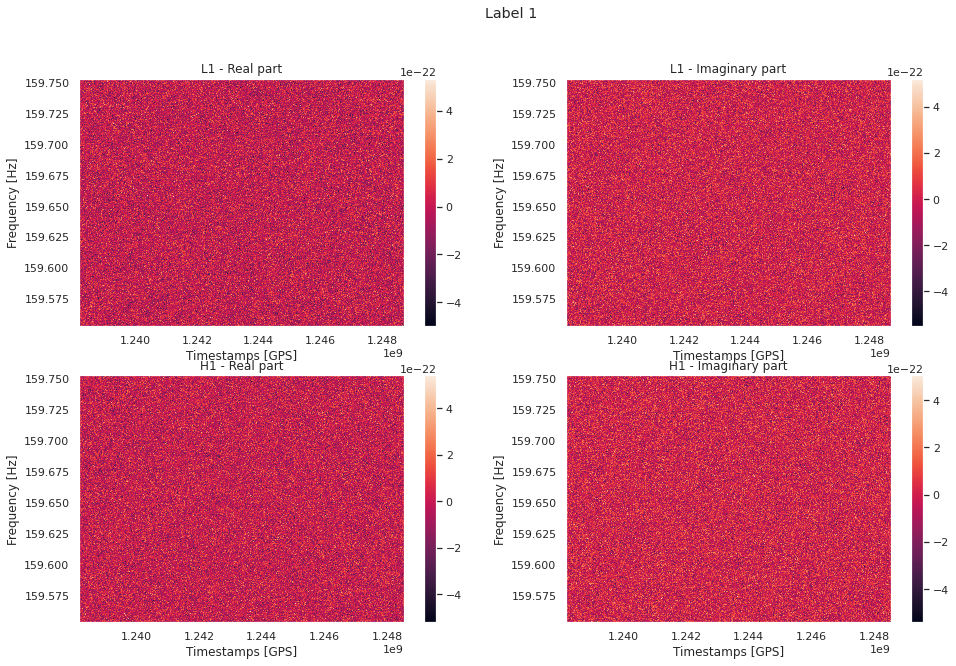

In [42]:
data = extract_data_from_hdf5(train_example_with_signal_path, labels_df)
plot_spectograms(data)

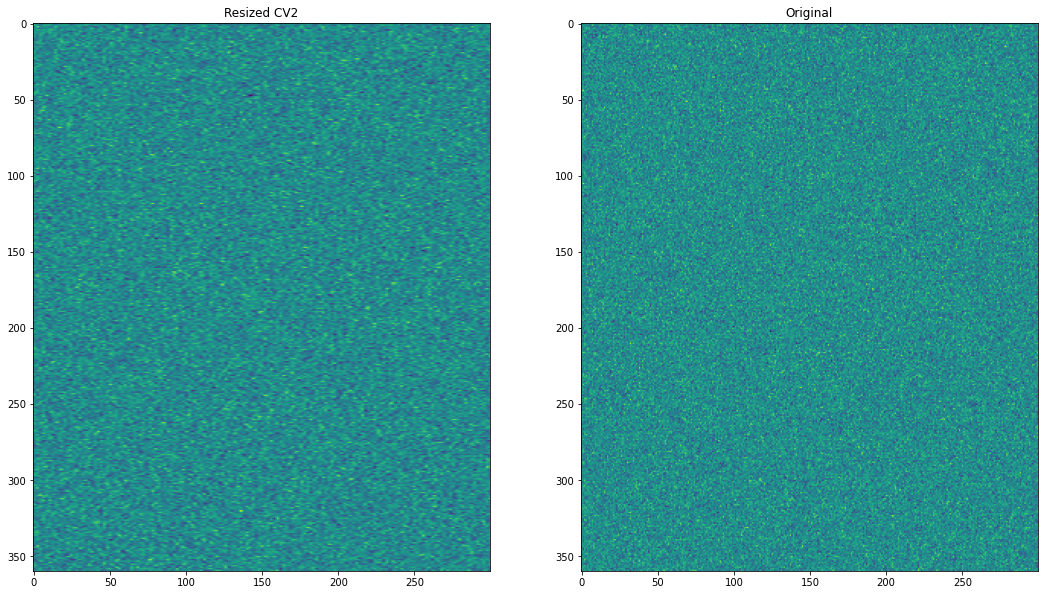

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 14)
ax1.imshow(qq2[:, 0:300])
ax1.set_title('Resized CV2')
ax2.imshow(amp_max.real[:, 0:300])
ax2.set_title('Original');
# plt.savefig('Min Comparison')

In [31]:
p = os.listdir(TRAIN_PATH)[98]
data = extract_data_from_hdf5(DATA_PATH/'train'/p, labels_df)
amp_max = data['L1_SFTs_amplitudes'].T

qq2 = cv2.resize(amp_max.real, dsize=(360, MIN), interpolation=cv2.INTER_CUBIC)
qq2 = (qq2-qq2.min())/(qq2.max()-qq2.min())

qq3 = np.random.choice(amp_max.flatten(), (360, 718)).reshape(360, 718).real.T

qq2 = resize_data_ts(amp_max.T, MEAN)

amp_max.shape, qq2.shape, qq3.shape

NameError: name 'qq2' is not defined

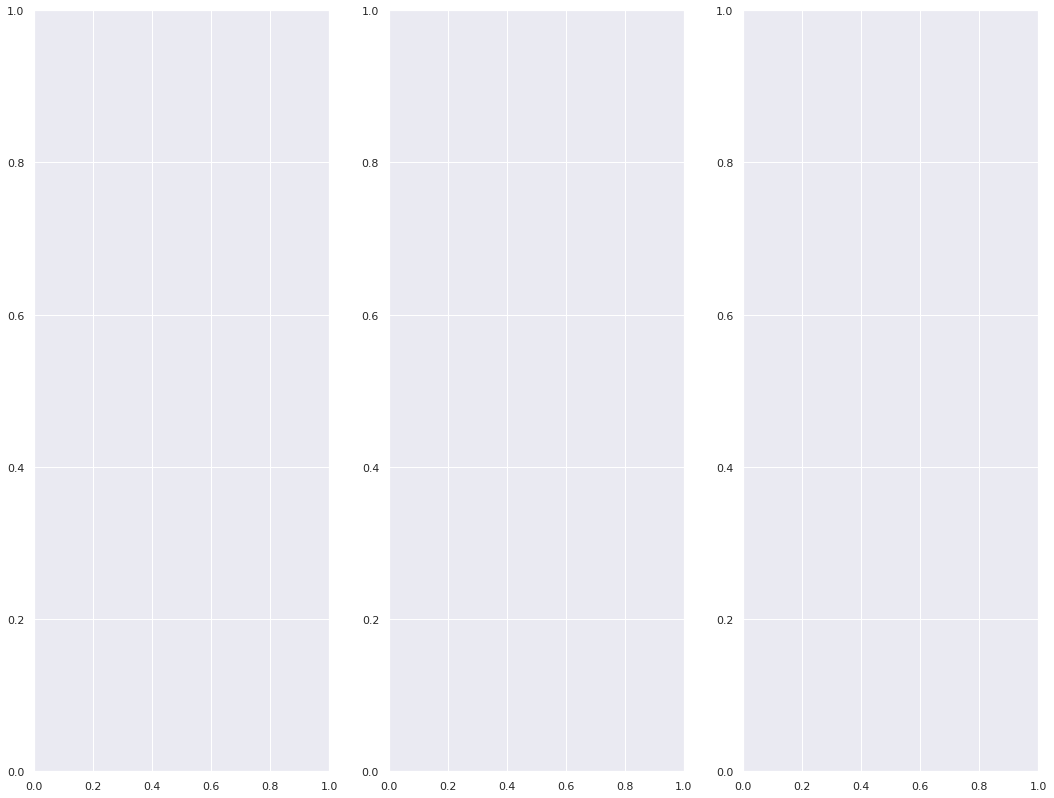

In [95]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 14)
ax1.imshow(qq2[0:300, :])
ax1.set_title('Resized CV2')
ax2.imshow(amp_max.real[0:300, :])
ax2.set_title('Original');
ax3.imshow(qq3[0:300, :])
ax3.set_title('Randomly Sampled');
plt.savefig('Min Comparison')

In [52]:
qq1 = cv2.resize(amp_min.real, dsize=(360, 4817), interpolation=cv2.INTER_CUBIC).T

qq1 = (qq1-qq1.min())/(qq1.max()-qq1.min())

NameError: name 'qq1' is not defined

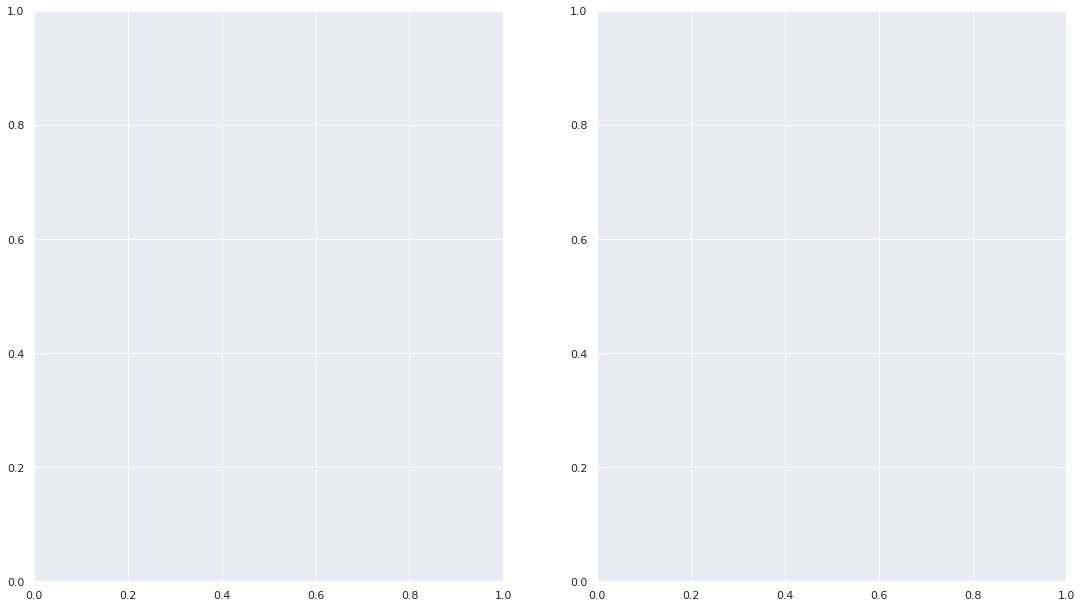

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(qq1[:, 0:300])
ax1.set_title('Interpolated')
ax2.imshow(amp_min.real[:, 0:300])
ax2.set_title('Original');
plt.save_fig('Max Comparison')

In [4]:
def resize_data(amp, optime):
    shape = len(amp[0])
    if shape == optime: return amp
    method = cv2.INTER_AREA if shape > optime else cv2.INTER_CUBIC
#         return np.random.choice(amp.flatten(), (len(amp), optime)).reshape(len(amp), optime)
    qq1 = cv2.resize(amp.real, dsize=(amp.shape[0], optime), interpolation=method).T
    return (qq1-qq1.min())/(qq1.max()-qq1.min())

In [5]:
labels_df = labels_df.loc[labels_df['target'] != -1]

labels = os.listdir(TRAIN_PATH)
labels.remove("50f09e37e.hdf5")
labels.remove("62b0dd011.hdf5")
labels.remove("b7666b451.hdf5")
len(labels)

600

In [6]:
TEST_SIZE = 200

In [8]:
freq_df = pd.DataFrame()
# for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
for p in tqdm(submission_df['id'][:TEST_SIZE], total=TEST_SIZE): #labels[:DATA_SIZE], total=DATA_SIZE):
    final_data = dict()
#     data = extract_data_from_hdf5(DATA_PATH/'train'/p, labels_df)
    data = extract_test_data_from_hdf5(os.path.join(DATA_PATH/'test', p+'.hdf5'))
    amp1 = data['L1_SFTs_amplitudes']
    amp2 = data['H1_SFTs_amplitudes']
#     amp1 = resize_data(amp1, OPTIMAL)
#     amp2 = resize_data(amp2, OPTIMAL)
    amp1 = amp1[:, :OPTIMAL]
    amp2 = amp1[:, :OPTIMAL]
    final_data['L1_resampled_time'] = amp1.real**2 + amp1.imag**2
    final_data['H1_resampled_time'] = amp2.real**2 + amp2.imag**2
#     final_data['label'] = data['label']
    freq_df = freq_df.append(final_data, ignore_index=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
del amp1, amp2, final_data, data
gc.collect()

freq_df = freq_df.sample(frac=1.0)

In [ ]:
freq_df = pd.read_pickle("/kaggle/input/freq2/OG_FR")

In [5]:
freq_df = pd.read_csv("/kaggle/input/freq-data/freq_df.csv")
len(freq_df)
freq_df.head()

In [54]:
# !rm -r h1_images
# !rm -r l1_images
!mkdir h1_images/
!mkdir l1_images/

i = 0
for p in tqdm(labels, total=len(labels)):
    data = extract_data_from_hdf5(DATA_PATH/'train'/p, df) #labels_df)
    amp1 = data['L1_SFTs_amplitudes']
    amp2 = data['H1_SFTs_amplitudes']
    
    cv2.imwrite(f"/kaggle/working/l1_images/sample_{i}.png", amp1.real)
    cv2.imwrite(f"/kaggle/working/h1_images/sample_{i}.png", amp2.real)
    i+=1

!zip -r l1images.zip l1_images

from IPython.display import FileLink 
FileLink(r'l1images.zip')

!zip -r h1images.zip h1_images

FileLink(r'h1images.zip')

amp2 = cv2.imread("/kaggle/working/h1_images/sample_145.png", 0) #Using 0 to read in grayscale mode
print(amp1.shape,amp2.shape)

fig = plt.figure(figsize=(15, 20))
axes = fig.subplots()
plt.imshow(amp2);

In [ ]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)

def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

filters = get_filters(filter_points, FFT_size)

# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

## Reviewing Cepstral coefficents

cepstral_coefficents[:, 0]

plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

## Constants
* Min (144) = 718
* L1 Max (98) = 4817 
* H1 Max (73) = 4843
* Mean (90) = 4561.69334

In [10]:
X_l_test = np.asarray(freq_df['L1_resampled_time'].to_list())
X_h_test = np.asarray(freq_df['H1_resampled_time'].to_list())

In [16]:
X_l_train, X_l_test = train_test_split(np.asarray(freq_df['L1_resampled_time'].to_list()), test_size=0.25, random_state=42)
X_h_train, X_h_test = train_test_split(np.asarray(freq_df['H1_resampled_time'].to_list()), test_size=0.25, random_state=42)

y_train, y_test = train_test_split(np.asarray(freq_df['label'].to_list()), test_size=0.25, random_state=42)

In [11]:
del freq_df
gc.collect()

46

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [11]:
import torch

class Dataset(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, data_type_path, df):
        self.data_type_path = data_type_path
        self.df = df
        self.good_shape = (360, 4096)

    def __len__(self):
        return len(self.df)
    
    def resize_data(self, amp, optime):
        shape = len(amp[0])
        if shape == optime: return amp
        method = cv2.INTER_AREA if shape > optime else cv2.INTER_CUBIC
    # return np.random.choice(amp.flatten(), (len(amp), optime)).reshape(len(amp), optime)
        qq1 = cv2.resize(amp.real, dsize=(amp.shape[0], optime), interpolation=method).T
        return (qq1-qq1.min())/(qq1.max()-qq1.min())
    
    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        file_id = r.id

        img = np.empty((2, 360, 128), dtype=np.float32)

        filename = '%s/%s.hdf5' % (self.data_type_path, file_id)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64

#                 p = a.real**2 + a.imag**2  # power
                if a.real.shape[1] == self.good_shape[1]:
                    p = a.real
                    p /= np.mean(p)  # normalize
                else:
                    p = self.resize_data(a.real, self.good_shape[1])
                p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128

                img[ch] = p

        return img, y

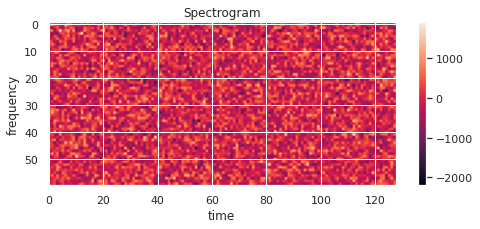

In [12]:
dataset = Dataset(TRAIN_PATH, labels_df)
img, y = dataset[10]

plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 300:360])  # zooming in for dataset[10]
plt.colorbar()
plt.show()

In [48]:
def get_arrays(size):
    X_train, y_train = [], []
    for i in tqdm(range(size)):
        qq1, y = dataset[i]
        img = (qq1-qq1.min())/(qq1.max()-qq1.min())
        X_train.append(img.tolist())
        y_train.append(y)
    return np.array(X_train), np.array(y_train)
X_train, y_train = get_arrays(150)

In [18]:
SAMPLES, TIMESTEPS, FEATURES = 2, 360, OPTIMAL

In [19]:
def create_lstm(x_input):
    lstm = tf.keras.Sequential([
#         TimeDistributed(Bidirectional(LSTM(128, input_shape=(SAMPLES, TIMESTEPS, FEATURES), return_sequences=True))),
#         Dropout(0.2),

#         TimeDistributed(Bidirectional(LSTM(128, return_sequences=True))),
#         Dropout(0.2),

#         TimeDistributed(Bidirectional(LSTM(128, return_sequences=True))),
#         Dropout(0.2),

        tf.keras.layers.LSTM(128, kernel_initializer='normal',input_shape=(TIMESTEPS, FEATURES), return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(128, kernel_initializer='normal', return_sequences=True),

        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(128, kernel_initializer='normal', return_sequences=False),
        tf.keras.layers.Dropout(0.2),
#         Flatten(),
        Dense(units=128, kernel_initializer='normal', activation='relu', 
          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
          bias_regularizer=regularizers.L2(1e-2),
          activity_regularizer=regularizers.L2(1e-3)),
        Dropout(0.5)
    ])
    
    x = lstm(x_input)
    x = Dense(128, activation='relu')(x)
    return x

In [20]:
def get_lstm_model():
    # 1) Hanford 
    h_input = Input(shape=(TIMESTEPS, FEATURES), name='x_h')
#     hl_input = Input(shape=(SAMPLES, TIMESTEPS, FEATURES), name='x_hl')

    # 2) Livingston 
    l_input = Input(shape=(TIMESTEPS, FEATURES), name='x_l')
    
    h_out = create_lstm(h_input)
    l_out = create_lstm(l_input)

    
    # Concatenate embeddings
    x = Concatenate()([h_out, l_out])
    x = Dropout(0.5)(x)
    x = Dense(128, kernel_initializer='normal', activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    # Model
    inputs = [h_input, l_input]
    model = Model(inputs=inputs, outputs=output)
    
    optimizer = 'adam'

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = [
            tf.keras.metrics.AUC() ,
        ]
    )
    return model

In [21]:
tf.keras.backend.clear_session()
gc.collect()
lstmmodel = get_lstm_model()
lstmmodel.summary()

2023-01-03 18:14:10.548692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 18:14:10.549650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 18:14:10.696839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 18:14:10.697771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 18:14:10.698644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_h (InputLayer)                [(None, 360, 4096)]  0                                            
__________________________________________________________________________________________________
x_l (InputLayer)                [(None, 360, 4096)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          2442880     x_h[0][0]                        
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          2442880     x_l[0][0]                        
______________________________________________________________________________________________

In [23]:
lstmhistory = lstmmodel.fit(
    x=[X_l_train, X_h_train],
    y=y_train,
    epochs = 35,
    validation_split=0.2,
    verbose = 2,
)

2023-01-03 18:16:44.831263: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 707788800 exceeds 10% of free system memory.
2023-01-03 18:16:45.627125: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 707788800 exceeds 10% of free system memory.
2023-01-03 18:16:46.441310: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 707788800 exceeds 10% of free system memory.
2023-01-03 18:16:47.099541: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 707788800 exceeds 10% of free system memory.
2023-01-03 18:16:47.742085: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/35


2023-01-03 18:16:54.963219: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188743680 exceeds 10% of free system memory.
2023-01-03 18:16:56.938539: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4/4 - 15s - loss: 2.0408 - auc: 0.5000 - val_loss: 1.9532 - val_auc: 0.5000
Epoch 2/35
4/4 - 2s - loss: 1.9081 - auc: 0.5000 - val_loss: 1.8271 - val_auc: 0.5000
Epoch 3/35
4/4 - 2s - loss: 1.7854 - auc: 0.5635 - val_loss: 1.7107 - val_auc: 0.5000
Epoch 4/35
4/4 - 2s - loss: 1.6721 - auc: 0.5000 - val_loss: 1.6036 - val_auc: 0.5000
Epoch 5/35
4/4 - 2s - loss: 1.5679 - auc: 0.5000 - val_loss: 1.5052 - val_auc: 0.5000
Epoch 6/35
4/4 - 2s - loss: 1.4724 - auc: 0.5000 - val_loss: 1.4149 - val_auc: 0.5000
Epoch 7/35
4/4 - 2s - loss: 1.3846 - auc: 0.5000 - val_loss: 1.3322 - val_auc: 0.5000
Epoch 8/35
4/4 - 2s - loss: 1.3042 - auc: 0.5000 - val_loss: 1.2565 - val_auc: 0.5000
Epoch 9/35
4/4 - 2s - loss: 1.2310 - auc: 0.4683 - val_loss: 1.1881 - val_auc: 0.5000
Epoch 10/35
4/4 - 2s - loss: 1.1648 - auc: 0.5000 - val_loss: 1.1261 - val_auc: 0.5000
Epoch 11/35
4/4 - 2s - loss: 1.1048 - auc: 0.5000 - val_loss: 1.0702 - val_auc: 0.5000
Epoch 12/35
4/4 - 2s - loss: 1.0508 - auc: 0.5000 - val_loss: 

In [31]:
lstmmodel.save('/kaggle/working/lstmmodel_freq_optimal')

In [48]:
!zip -r lstmmodel_freq_optimal.zip lstmmodel_freq_optimal

from IPython.display import FileLink 
FileLink(r'lstmmodel_freq_optimal.zip')

/kaggle/working/lstmmodel_freq_optimal.zip

In [22]:
del X_l_train, X_h_train, y_train
gc.collect()

13903

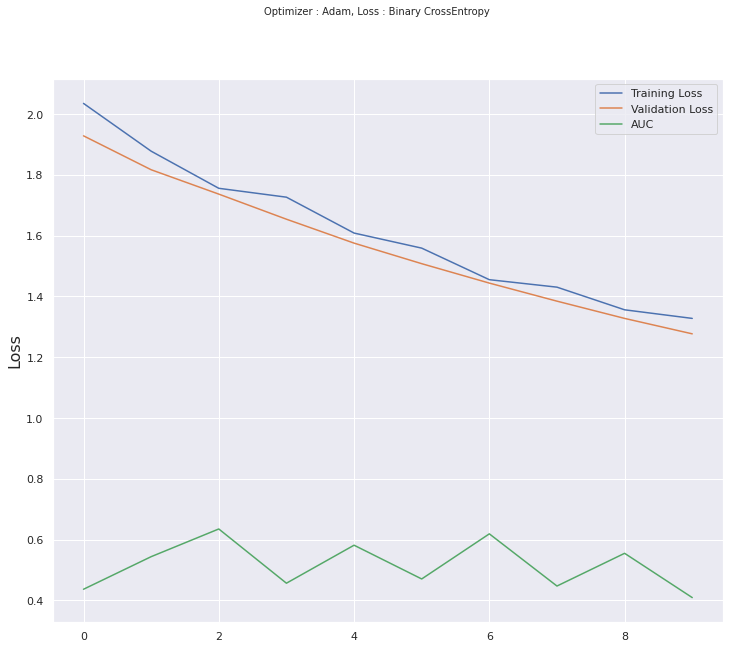

In [21]:
plt.figure(figsize=(12,10))

plt.suptitle('Optimizer : Adam, Loss : Binary CrossEntropy', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(lstmhistory.history['loss'], label='Training Loss')
plt.plot(lstmhistory.history['val_loss'], label='Validation Loss')
plt.plot(lstmhistory.history['auc'], label='AUC')
plt.legend(loc='upper right');

In [22]:
del lstmhistory
gc.collect()

3626

In [23]:
score = lstmmodel.evaluate([X_l_test, X_h_test], y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 1.193725347518921
Test accuracy: 0.5


In [20]:
lstmmodel = tf.keras.models.load_model('/kaggle/input/lstmmodel-freq-optimal/lstmmodel_freq_optimal')

2023-01-03 18:47:47.079735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 18:47:47.080686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 18:47:47.207395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 18:47:47.208251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 18:47:47.209090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [21]:
preds = lstmmodel.predict([X_l_test, X_h_test])
preds

2023-01-03 18:48:04.982842: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1179648000 exceeds 10% of free system memory.
2023-01-03 18:48:06.312100: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1179648000 exceeds 10% of free system memory.
2023-01-03 18:48:07.636403: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1179648000 exceeds 10% of free system memory.
2023-01-03 18:48:08.564240: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1179648000 exceeds 10% of free system memory.
2023-01-03 18:48:09.557339: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-03 18:48:11.294335: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188743680 exceeds 10% of free system memory.
2023-01-03 18:48:13.200780: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


array([[0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.53181833],
       [0.531

In [28]:
submission_df

,id,target
0,00054c878,0.5
1,0007285a3,0.5
2,00076c5a6,0.5
3,001349290,0.5
4,001a52e92,0.5
...,...,...
7970,ffbce04ef,0.5
7971,ffc2d976b,0.5
7972,ffc905909,0.5
7973,ffe276f3e,0.5


In [32]:
test = []
for s in range(7975):
    test.append(0.53181833)

In [33]:
submission_df['target'] = test

In [39]:
submission_df

,id,target
0,00054c878,0.531818
1,0007285a3,0.531818
2,00076c5a6,0.531818
3,001349290,0.531818
4,001a52e92,0.531818
...,...,...
7970,ffbce04ef,0.531818
7971,ffc2d976b,0.531818
7972,ffc905909,0.531818
7973,ffe276f3e,0.531818


In [40]:
submission_df.to_csv(r'/kaggle/working/sample_submission1.csv', index=False)

In [37]:
del X_l_test, X_h_test, y_test
gc.collect()

7061

In [ ]:
lstmmodel.save('lstmmodel')
!zip -r file.zip ./lstmmodel

from IPython.display import FileLink 
FileLink(r'file.zip')

* 30 epochs
 * Mean Prediction Mean = 0.724526 
     * Test loss: 0.8648967146873474
     * Test accuracy: 0.5166666507720947
 * Min Prediction Mean 
     * Downsampling through random.choice np function = 0.6275969
     * Using inter_area interp = 0.6284645
 * Max Prediction Mean = 0.6495114
* 50 epochs
 * Lower prediction accuracy (overfitting?)
* 40 epochs
 * Mean Prediction Mean = 0.7058157
 * Mean Prediction Mean (inverted data) = 0.6863829
* ISTFT Prediction Mean = 0.67515224

In [4]:
def get_label(path, labels):
    with h5py.File(path, "r") as f:
        ID_key = list(f.keys())[0]
        return labels.loc[labels.id==ID_key].target.item()

In [8]:
get_label(DATA_PATH/'train'/os.listdir(TRAIN_PATH)[144], labels_df)

-1

In [27]:
data = extract_data_from_hdf5(DATA_PATH/'train'/labels[0], labels_df)
l1 = data['L1_SFTs_amplitudes'].real

TypeError: Image data of dtype object cannot be converted to float

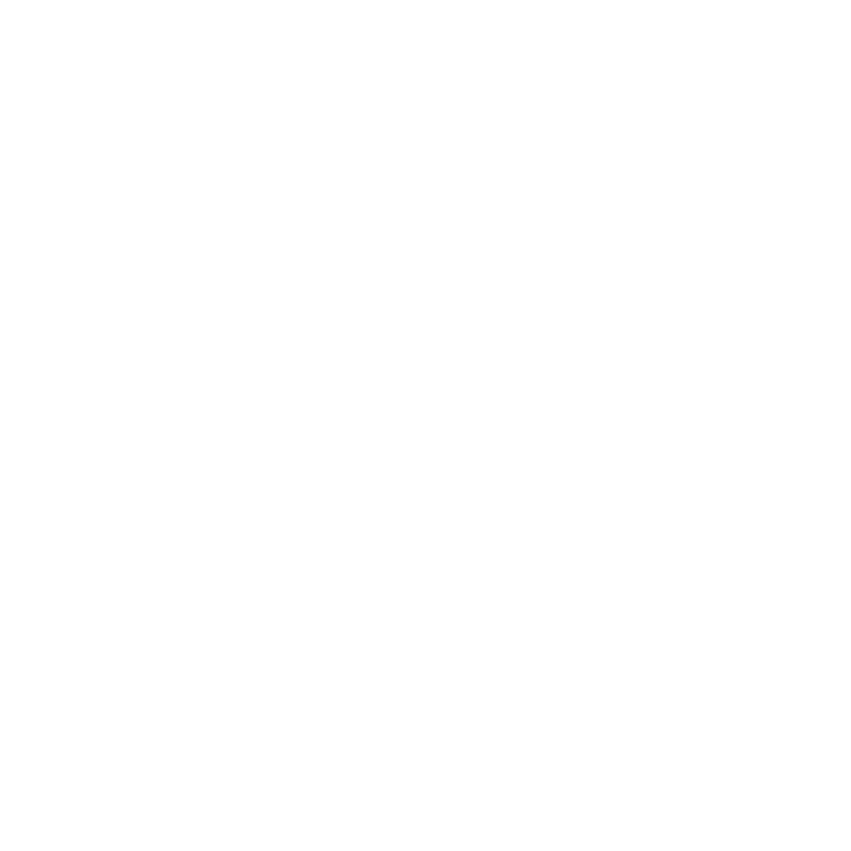

In [26]:
fig = plt.figure(figsize=(15, 20))
axes = fig.subplots()

plt.axis('off')
axes.imshow(freq_df['L1_resampled_time'][[0]]);

TypeError: Image data of dtype object cannot be converted to float

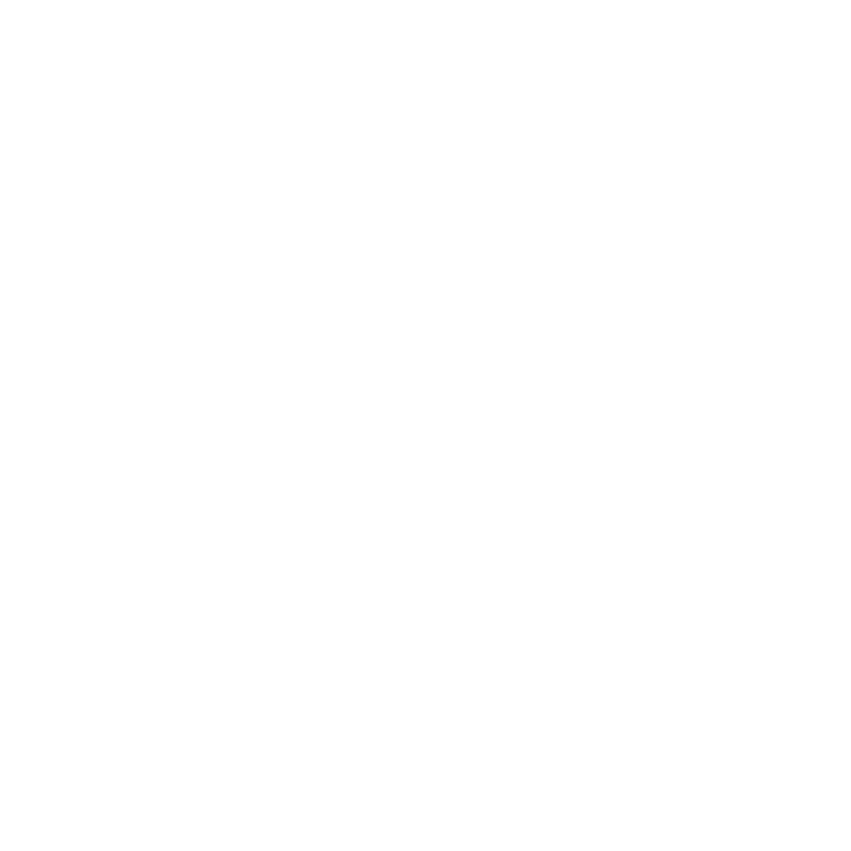

In [25]:
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
%matplotlib inline 

# freq_df = pd.read_csv("/kaggle/input/freq_data_df.csv") # If using kaggle
freq_df = pd.read_csv("freq_df.csv", delimiter=',')

fig = plt.figure(figsize=(15, 20))
axes = fig.subplots()

plt.axis('off')
axes.imshow(freq_df['L1_resampled_time'][[0]]);

  0%|          | 0/444 [00:00<?, ?it/s]

KeyboardInterrupt: 

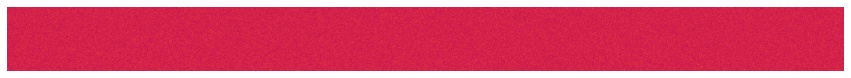

In [142]:
fig = plt.figure(figsize=(15, 20))
axes = fig.subplots()

for s in tqdm(range(156, time_df.shape[0])):
    plt.axis('off')
    axes.imshow(time_df['L1_resampled_time'][s].real);
    fig.savefig(f'/kaggle/working/l1_images/sample_{s}.png', bbox_inches='tight')

In [204]:
!zip -r l1images.zip l1_images

from IPython.display import FileLink 
FileLink(r'l1images.zip')

  adding: l1_images/ (stored 0%)
  adding: l1_images/dataname_412.png (deflated 13%)
  adding: l1_images/dataname_420.png (deflated 13%)
  adding: l1_images/dataname_336.png (deflated 13%)
  adding: l1_images/dataname_97.png (deflated 13%)
  adding: l1_images/dataname_111.png (deflated 13%)
  adding: l1_images/dataname_553.png (deflated 13%)
  adding: l1_images/dataname_489.png (deflated 12%)
  adding: l1_images/dataname_135.png (deflated 13%)
  adding: l1_images/dataname_400.png (deflated 13%)
  adding: l1_images/dataname_529.png (deflated 13%)
  adding: l1_images/dataname_433.png (deflated 13%)
  adding: l1_images/dataname_359.png (deflated 13%)
  adding: l1_images/dataname_406.png (deflated 13%)
  adding: l1_images/dataname_15.png (deflated 13%)
  adding: l1_images/dataname_594.png (deflated 13%)
  adding: l1_images/dataname_267.png (deflated 13%)
  adding: l1_images/dataname_186.png (deflated 13%)
  adding: l1_images/dataname_392.png (deflated 13%)
  adding: l1_images/dataname_119.

/kaggle/working/l1images.zip

In [ ]:
fig = plt.figure(figsize=(15, 20))
axes = fig.subplots()

for s in tqdm(range(time_df.shape[0])):
    plt.axis('off')
    axes.imshow(time_df['H1_resampled_time'][s].real);
    fig.savefig(f'/kaggle/working/h1_images/sample_{s}.png', bbox_inches='tight')

In [ ]:
!zip -r h1images.zip h1_images

FileLink(r'h1images.zip')

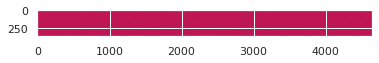

In [156]:
from os import path

outpath = "/kaggle/working/h1_images/"

fig, ax = plt.subplots()        # generate figure with axes
image = ax.imshow(time_df['H1_resampled_time'][0].real)
plt.draw()
fig.savefig(path.join(outpath,"dataname_0.png"));

In [169]:
for j in tqdm(range(100, 600)):
    image.set_data(time_df['H1_resampled_time'][j].real)
    plt.draw()
    fig.savefig(path.join(outpath,"dataname_{0}.png".format(j)));

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

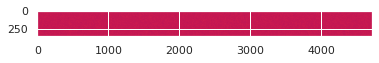

In [178]:
outpath = "/kaggle/working/l1_images/"

fig, ax = plt.subplots()        # generate figure with axes
image = ax.imshow(time_df['L1_resampled_time'][0].real)
plt.draw()
fig.savefig(path.join(outpath,"dataname_0.png"));

In [179]:
for j in tqdm(range(1, 600)):
    image.set_data(time_df['L1_resampled_time'][j].real)
    plt.draw()
    fig.savefig(path.join(outpath,"dataname_{0}.png".format(j)));

  0%|          | 0/599 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

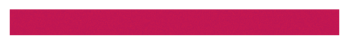

In [176]:
im = plt.imread("/kaggle/working/l1_images/sample_15.png")
fig, ax = plt.subplots()
save
ax.imshow(im);

In [12]:
from pathlib import Path

i = 0
for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
    data = extract_data_from_hdf5(DATA_PATH/'train'/p, labels_df)
    l1 = data['L1_SFTs_amplitudes'].real

    fig = plt.figure(figsize=(15, 20))
    axes = fig.subplots()
    axes.set_title('Sample '+str(i))
    axes.set_xlabel('Time');
    axes.set_ylabel('Frequency');

    axes.imshow(l1)

    fig.savefig('/kaggle/working/l1_images/sample '+str(i)+'.png')
    plt.close()
    
    h1 = data['H1_SFTs_amplitudes'].real
    fig = plt.figure(figsize=(15, 20))
    axes = fig.subplots()
    axes.set_title('Sample '+str(i))
    axes.set_xlabel('Time');
    axes.set_ylabel('Frequency');

    axes.imshow(h1)
    fig.savefig('/kaggle/working/h1_images/sample '+str(i)+'.png')
    plt.close()

    i+=1
print(i)

  0%|          | 0/108 [00:00<?, ?it/s]

603


In [221]:
freq_df['L1_resampled_time'] = freq_df['L1_resampled_time'].apply(lambda x: np.complex(x))
freq_df.head()

ValueError: complex() arg is a malformed string

In [109]:
from IPython.display import FileLink 
FileLink(r"l1_images/sample 4.png")

/kaggle/working/l1_images/sample 4.png

In [177]:
!rm -r h1_images
!rm -r l1_images
!mkdir h1_images/
!mkdir l1_images/

In [109]:
labels_list = []
for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
    labels_list.append(get_label(DATA_PATH/'train'/p, labels_df))

  0%|          | 0/603 [00:00<?, ?it/s]

In [112]:
np.savetxt('labels_list.csv', labels_list)

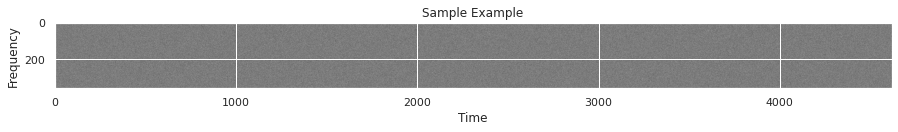

In [212]:
p = os.listdir(TRAIN_PATH)[146]
data = extract_data_from_hdf5(DATA_PATH/'train'/p, labels_df)
l1 = data['L1_SFTs_amplitudes'].real

fig = plt.figure(figsize=(15, 20))
axes = fig.subplots()
axes.set_title('Sample Example')
axes.set_xlabel('Time');
axes.set_ylabel('Frequency');

axes.imshow(l1, cmap='gray')

fig.savefig('/kaggle/working/l1_images/sample test.png', bbox='tight')

error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 4


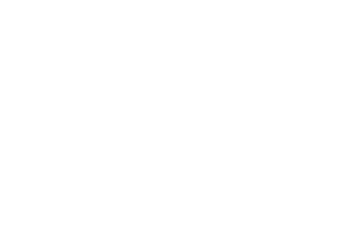

In [218]:
im = plt.imread("/kaggle/working/l1_images/sample test.png")
fig, ax = plt.subplots()
plt.axis("off")
plt.imshow(cv2.cvtColor(im, cv2.COLOR_GRAY2RGB));

In [205]:
!zip -r h1images.zip h1_images

from IPython.display import FileLink 
FileLink(r'h1images.zip')

  adding: h1_images/ (stored 0%)
  adding: h1_images/dataname_412.png (deflated 19%)
  adding: h1_images/dataname_420.png (deflated 19%)
  adding: h1_images/dataname_336.png (deflated 19%)
  adding: h1_images/dataname_97.png (deflated 15%)
  adding: h1_images/dataname_111.png (deflated 19%)
  adding: h1_images/dataname_553.png (deflated 19%)
  adding: h1_images/dataname_489.png (deflated 19%)
  adding: h1_images/dataname_135.png (deflated 19%)
  adding: h1_images/dataname_400.png (deflated 19%)
  adding: h1_images/dataname_529.png (deflated 19%)
  adding: h1_images/dataname_433.png (deflated 19%)
  adding: h1_images/dataname_359.png (deflated 19%)
  adding: h1_images/dataname_406.png (deflated 19%)
  adding: h1_images/dataname_15.png (deflated 15%)
  adding: h1_images/dataname_594.png (deflated 19%)
  adding: h1_images/dataname_267.png (deflated 19%)
  adding: h1_images/dataname_186.png (deflated 19%)
  adding: h1_images/dataname_392.png (deflated 19%)
  adding: h1_images/dataname_119.

/kaggle/working/h1images.zip

In [ ]:
!zip -r l1images.zip l1_images

from IPython.display import FileLink 
FileLink(r'l1images.zip')

In [ ]:
%%time
train_df = pd.DataFrame()
for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
    data = extract_data_from_hdf5_reduced(DATA_PATH/'train'/p, labels_df)
    train_df = train_df.append(data, ignore_index=True)

In [8]:
train_df.head()

NameError: name 'train_df' is not defined

In [ ]:
train_df = train_df.loc[train_df['label'] != -1]

## Frequencies Distribution

In [54]:
plt.figure(figsize=(14,6))
sns.histplot(x=list(np.hstack(train_df['freq'])), stat="density", common_norm=False, bins=40, kde=True)
plt.title('Histogram of the range of Frequencies detected');
plt.xlabel('Frequency Hz')
plt.show()

NameError: name 'train_df' is not defined

<Figure size 1008x432 with 0 Axes>

## Time stamps Distribution

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(24,8))
fig.suptitle(f"In the plots the distribution of timestamps for both classes are shown; 1 indicates a simulated CW present and 0 not present", fontsize=16)
sns.histplot(
        x=list(len(i) for i in train_df['L1_ts']),hue=train_df['label'],
        stat="density", common_norm=False, bins=20, ax=ax[0], kde=True).set_title('Length of measurement for Livingston detector', fontsize=16);

sns.histplot(
        x=list(len(i) for i in train_df['H1_ts']),hue= train_df['label'], 
        stat="density", common_norm=False, bins=20, ax=ax[1], kde=True).set_title('Length of measurement for Hanford detector', fontsize=16);

## Simulating gravitational waves and evaluating their detectability in Python

Riroriro is a Python package to simulate the gravitational waveforms of binary mergers of black holes and/or neutron stars, and calculate several properties of these mergers and waveforms, specifically relating to their observability by gravitational wave detectors."

"The gravitational waveform simulation of Riroriro is based upon the methods of Buskirk and Babiuc-Hamilton (2019), a paper which describes a computational implementation of an earlier theoretical gravitational waveform model by Huerta et al. (2017), using post-Newtonian expansions and an approximation called the implicit rotating source to simplify the Einstein field equations and simulate gravitational waves. Riroriro's calculation of signal-to-noise ratios (SNR) of gravitational wave events is based on the methods of Barrett et al. (2018), with the simpler gravitational wave model Findchirp (Allen et al. (2012)) being used for comparison and calibration in these calculations."

<a href=https://arxiv.org/abs/2103.06943>Link for the paper</a>

#### cc. of GW simulation: this part was written by <a href=https://www.kaggle.com/code/mistag/reverse-engineering-create-clean-gw-signals>Geir Drange</a> and presented by <a href=https://www.kaggle.com/code/mpwolke/g-waves-riroriro>Marília Prata</a>




"Riroriro is a set of Python modules containing functions to simulate the gravitational waveforms of mergers of black holes and/or neutron stars, and calculate several properties of these mergers and waveforms, specifically relating to their observability by gravitational wave detectors. Riroriro combines areas covered by previous gravitational wave models (such as gravitational wave simulation, SNR calculation, horizon distance calculation) into a single package with broader scope and versatility in Python, a programming language that is ubiquitous in astronomy. Aside from being a research tool, Riroriro is also designed to be easy to use and modify, and it can also be used as an educational tool for students learning about gravitational waves."

"The modules “inspiralfuns”, “mergerfirstfuns”, “matchingfuns”, “mergersecondfuns” and “gwexporter”, in that order, can be used to simulate the strain amplitude and frequency of a merger gravitational waveform. The module “snrcalculatorfuns” can compare such a simulated waveform to a detector noise spectrum to calculate a signal-to-noise ratio (SNR) for that signal for that detector. The module “horizondistfuns” calculates the horizon distance of a merger given its waveform, and the module “detectabilityfuns” evaluates the detectability of a merger given its SNR."

More information on the pip installation can be found here: https://pypi.org/project/riroriro/

Tutorials for Riroriro can be found here: https://github.com/wvanzeist/riroriro_tutorials

Full documentation of each of the functions of Riroriro can be found here: https://wvanzeist.github.io/

https://github.com/wvanzeist/riroriro

In [ ]:
# Code by Geir Drange https://www.kaggle.com/code/mistag/reverse-engineering-create-clean-gw-signals

# Parameters:
# logMC: system mass (0.0-2.0)
# q: mass ratio (0.1-1.0)
# D: distance (Mpc)
# merger_type: 'BH'=binary black hole merger, 'NS'=binary neutron star merger
# flow: low frequency (Hz) 
def gen_gw(logMc=1.4, q=0.8, D=100.0, flow=10.0, merger_type='BH'):
    M, eta = ins.get_M_and_eta(logMc=logMc,q=q)
    start_x = ins.startx(M,flow)
    end_x = ins.endx(eta,merger_type)
    x, xtimes, dt = ins.PN_parameter_integration(start_x,end_x,M,eta)
    realtimes = ins.inspiral_time_conversion(xtimes,M)
    i_phase, omega, freq = ins.inspiral_phase_freq_integration(x,dt,M)
    r, rdot = ins.radius_calculation(x,M,eta)
    A1, A2 = ins.a1_a2_calculation(r,rdot,omega,D,M,eta)
    i_Aorth, i_Adiag = ins.inspiral_strain_polarisations(A1,A2,i_phase)
    i_amp = ins.inspiral_strain_amplitude(i_Aorth,i_Adiag)
    i_time = realtimes
    i_omega = omega
    sfin, wqnm = me1.quasi_normal_modes(eta)
    alpha, b, C, kappa = me1.gIRS_coefficients(eta,sfin)
    fhat, m_omega = me1.merger_freq_calculation(wqnm,b,C,kappa)
    fhatdot = me1.fhat_differentiation(fhat)
    m_time = me1.merger_time_conversion(M)
    min_switch_ind = mat.min_switch_ind_finder(i_time,i_omega,m_time,m_omega)
    final_i_index = mat.final_i_index_finder(min_switch_ind,i_omega,m_omega)
    time_offset = mat.time_offset_finder(min_switch_ind,final_i_index,i_time,m_time)
    i_m_time, i_m_omega = mat.time_frequency_stitching(min_switch_ind,final_i_index,time_offset,i_time,i_omega,m_time,m_omega)
    i_m_freq = mat.frequency_SI_units(i_m_omega,M)
    m_phase = me2.merger_phase_calculation(min_switch_ind,final_i_index,i_phase,m_omega)
    i_m_phase = me2.phase_stitching(final_i_index,i_phase,m_phase)
    m_amp = me2.merger_strain_amplitude(min_switch_ind,final_i_index,alpha,i_amp,m_omega,fhat,fhatdot)
    i_m_amp = me2.amplitude_stitching(final_i_index,i_amp,m_amp)
    m_Aorth, m_Adiag = me2.merger_polarisations(final_i_index,m_amp,m_phase,i_Aorth)
    i_m_Aorth, i_m_Adiag = me2.polarisation_stitching(final_i_index,i_Aorth,i_Adiag,m_Aorth,m_Adiag)
    return np.array(i_m_time), np.array(i_m_Aorth), np.array(i_m_Adiag), np.array(i_m_freq)

"The function returns two waves that represent orthogonal/diagonal waves. The output timescale that is returned is non-linear, so to convert these signals into uniform sampled signals as in the dataset, we need to resample. The function below will resample the gravitational wave signals to 2048Hz. It is crude though, based on nearest sample, but good enough for studying spectrums. Interpolation would be more proper."

In [ ]:
SR = 2048 # target sample rate (Hz)
# Parameters:
# dt: time series
# amp: amplitude signal
# seg: output sequence length (seconds)
def resample(dt, amp, seg=2.0):
    end = dt[-1]
    start = end - seg
    d = np.zeros(int(SR*seg))
    for i in range((int(SR*seg))):
        t = start + i/SR
        d[i] = amp[np.where(dt == dt[np.abs(dt-t).argmin()])[0][0]]
    return d

In [ ]:
def plot_sig(dt, sig1, sig2=None, seg=2.0):
    end = dt[-1]
    start = end - seg
    plt.figure(1)
    plt.plot(dt, sig1)
    peak = np.max(np.abs(sig1))
    plt.axis([start,end,np.min(sig1)-peak/10,np.max(sig1)+peak/10])
    if sig2 is not None:
        plt.plot(dt, sig2)
    plt.xlabel('Time (s)')
    plt.ylabel('Strain amplitude')

### Test signal generation

In [ ]:
m_time, m_Aorth, m_Adiag, m_freq = gen_gw(logMc=1.4, q=0.2)

### How Gravitational waves get detected

"When a gravitational wave passes by Earth, it squeezes and stretches space. LIGO can detect this squeezing and stretching. Each LIGO observatory has two “arms” that are each more than 2 miles (4 kilometers) long. A passing gravitational wave causes the length of the arms to change slightly. The observatory uses lasers, mirrors, and extremely sensitive instruments to detect these tiny changes."

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
plot_sig(m_time, m_Aorth, m_Adiag, seg=2)
plt.subplot(2, 1, 2)
plot_sig(m_time, m_Aorth, m_Adiag, seg=.1)

### Resample the signal to 2048Hz (only the orthogonal part)

In [ ]:
d1 = resample(m_time, m_Aorth, 2.0)

fig = plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plot_sig(m_time, m_Aorth, seg=2)
plt.title('Original')
plt.subplot(2, 2, 2)
plot_sig(m_time, m_Aorth, seg=.1)
plt.title('Original (zoomed)')
plt.subplot(2, 2, 3)
plt.plot(d1)
plt.title('Resampled to 2048Hz')
plt.subplot(2, 2, 4)
plt.plot(d1[-205:])
plt.title('Resampled to 2048Hz (zoomed)');

### Visualizing Frequency Vector

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(m_time, m_freq, label="Min: {}Hz, Max: {}Hz".format(int(np.min(m_freq)), int(np.max(m_freq))))
peak = np.max(np.abs(m_freq))
plt.axis([m_time[-1] - 2.0 if m_time[-1] >= 2.0 else m_time[0], m_time[-1], 0 , np.max(m_freq)+peak/10])
ax.legend()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)');

### Visualizing spectrum in frequency domain using Constant-Q transform

In [ ]:
hop_length = 64
C = np.abs(librosa.cqt(d1/np.max(d1), sr=SR, hop_length=hop_length, fmin=8, filter_scale=0.8, bins_per_octave=12))
fig, ax = plt.subplots(figsize=(6,6))
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=SR*2, hop_length=hop_length, bins_per_octave=12, ax=ax)
ax.set_title('Constant-Q power spectrum');

### Amplitude vs. Distance(Inverse square law verification)

In [ ]:
hop_length = 64

fig = plt.figure(figsize=(20,15))
dist = [100., 200., 400.]
for m in range(len(dist)):
    m_time, m_Aorth, _, m_freq = gen_gw(logMc=1.4, q=0.2, D=dist[m])
    rd = resample(m_time, m_Aorth, 2.0)
    # time series
    ax = plt.subplot(len(dist), 3, 1+m*3)
    plt.plot(rd)
    plt.title('Signal (D={} Mpc)'.format(int(dist[m])))
    # zoomed times series (chirp)
    ax = plt.subplot(len(dist), 3, 2+m*3)
    plt.plot(rd[-205:])
    plt.title('Signal chirp (zoomed)')
    # Q-Transform
    ax = plt.subplot(len(dist), 3, 3+m*3)
    if m == 0:
        smax = np.max(rd)
    C = np.abs(librosa.cqt(rd/smax, sr=SR, hop_length=hop_length, fmin=8, filter_scale=0.8, bins_per_octave=12))
    if m == 0:
        Cmax = np.max(C)
    img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=Cmax), # was np.max
                                   sr=SR*2, hop_length=hop_length, bins_per_octave=12, ax=ax)
    ax.set_title('Constant-Q power spectrum');

In [ ]:
# Generate signals with parameters drawn from a specific population
num_signals = 2

# These parameters describe background noise and data format
writer_kwargs = {
                "tstart": 1238166018,
                "duration": 4 * 30 * 86400,  
                "detectors": "H1,L1",        
                "sqrtSX": 1e-23,          
                "Tsft": 1800,             
                "SFTWindowType": "tukey", 
                "SFTWindowBeta": 0.01,
               }

In [ ]:
# This class allows us to sample signal parameters from a specific population.
# Implicitly, sky positions are drawn uniformly across the celestial sphere.
# PyFstat also implements a convenient set of priors to sample a population
# of isotropically oriented neutron stars.
signal_parameters_generator = pyfstat.AllSkyInjectionParametersGenerator(
    priors={
        "tref": writer_kwargs["tstart"],
        "F0": {"uniform": {"low": 100.0, "high": 100.1}},
        "F1": lambda: 10**stats.uniform(-12, 4).rvs(),
        "F2": 0,
        "h0": lambda: writer_kwargs["sqrtSX"] / stats.uniform(1, 10).rvs(),
        **pyfstat.injection_parameters.isotropic_amplitude_priors,
    },
)

In [ ]:
snrs = np.zeros(num_signals)

for ind in range(num_signals):

    # Draw signal parameters.
    # Noise can be drawn by setting `params["h0"] = 0
    params = signal_parameters_generator.draw()
    writer_kwargs["outdir"] = f"PyFstat_example_data_ensemble/Signal_{ind}"
    writer_kwargs["label"] = f"Signal_{ind}"
    
    writer = pyfstat.Writer(**writer_kwargs, **params)
    writer.make_data()
    
    # SNR can be compute from a set of SFTs for a specific set
    # of parameters as follows:
    snr = pyfstat.SignalToNoiseRatio.from_sfts(
        F0=writer.F0, sftfilepath=writer.sftfilepath
    )
    squared_snr = snr.compute_snr2(
        Alpha=writer.Alpha, 
        Delta=writer.Delta,
        psi=writer.psi,
        phi=writer.phi, 
        h0=writer.h0,
        cosi=writer.cosi
    )
    snrs[ind] = np.sqrt(squared_snr)
    
    # Data can be read as a numpy array using PyFstat
    frequency, timestamps, amplitudes = pyfstat.utils.get_sft_as_arrays(
        writer.sftfilepath
    )
    
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Signal {ind} - SNR: {snrs[ind]:.2f}")
    for d_ind, detector in enumerate(amplitudes.keys()):
        ax[d_ind][0].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Real part")
        ax[d_ind][1].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Imaginary part")
        
        c0 = ax[d_ind][0].pcolormesh(timestamps[detector], frequency,
                                     amplitudes[detector].real)
        c1 = ax[d_ind][1].pcolormesh(timestamps[detector], frequency,
                                     amplitudes[detector].imag)
        
        fig.colorbar(c0, ax=ax[d_ind][0])
        fig.colorbar(c1, ax=ax[d_ind][1])
    plt.show()

## Modeling with LSTM in Time Domain

Long short-term memory (LSTM) is an artificial neural network used in the fields of artificial intelligence and deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. Such a recurrent neural network (RNN) can process not only single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition, machine translation, robot control, video games, and healthcare. LSTM has become the most cited neural network of the 20th century.

<img src=https://www.mdpi.com/sensors/sensors-21-05625/article_deploy/html/images/sensors-21-05625-g001.png width=800/>

The name of LSTM refers to the analogy that a standard RNN has both "long-term memory" and "short-term memory". The connection weights and biases in the network change once per episode of training, analogous to how physiological changes in synaptic strengths store long-term memories; the activation patterns in the network change once per time-step, analogous to how the moment-to-moment change in electric firing patterns in the brain store short-term memories. The LSTM architecture aims to provide a short-term memory for RNN that can last thousands of timesteps, thus "long short-term memory".

A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications.

The compact forms of the equations for the forward pass of an LSTM cell with a forget gate are:

<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/dc89390b3136ccbbc223a1ed110c6d2b4856069c width=300/>

## Saving LSTM Model weights

In [ ]:
lstmmodel.save_weights('lstmmodel.h5')

## Releasing Memory

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector

In [ ]:
# define model
numberOfLSTMunits= 16
n_timesteps_in, n_features = 4, 10
input = Input(shape=(n_timesteps_in, n_features))
state_h = LSTM(numberOfLSTMunits, return_sequences=False) (input)
model1 = Model(inputs=input, outputs=state_h)
model1.summary()

## Modeling with Vision Transformers(ViT) and Convolutional Neural Network(CNN) in Frequency Domain

The concept of Vision Transformer (ViT) is an extension of the original concept of Transformer. It is only the application of Transformer in the image domain with slight modification in the implementation in order to handle the different data modality. More specifically, a ViT uses different methods for tokenization and embedding. However, the generic architecture remains the same. An input image is split into a set of image patches, called visual tokens. The visual tokens are embedded into a set of encoded vectors of fixed dimension. The position of a patch in the image is embedded along with the encoded vector and fed into the transformer encoder network which is essentially the same as the one responsible for processing the text input. 

<img src=https://miro.medium.com/max/1400/1*l37va2Mu8Snx6LLb13430A.png width=700/>

There are multiple blocks in the ViT encoder and each block consists of three major processing elements: Layer Norm, Multi-head Attention Network (MSP) and Multi-Layer Perceptrons (MLP). Layer Norm keeps the training process on track and let model adapt to the variations among the training images. MSP is a network responsible for generation of attention maps from the given embedded visual tokens. These attention maps help network focus on most important regions in the image such as object(s). 

## Convolutional Neural Network

In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of artificial neural network (ANN), most commonly applied to analyze visual imagery. CNNs are also known as Shift Invariant or Space Invariant Artificial Neural Networks (SIANN), based on the shared-weight architecture of the convolution kernels or filters that slide along input features and provide translation-equivariant responses known as feature maps. Counter-intuitively, most convolutional neural networks are not invariant to translation, due to the downsampling operation they apply to the input. They have applications in image and video recognition, recommender systems, image classification, image segmentation, medical image analysis, natural language processing, brain–computer interfaces, and financial time series.

<img src= https://production-media.paperswithcode.com/method_collections/cnn.jpeg width=700/>

CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "full connectivity" of these networks make them prone to overfitting data. Typical ways of regularization, or preventing overfitting, include: penalizing parameters during training (such as weight decay) or trimming connectivity (skipped connections, dropout, etc.) CNNs take a different approach towards regularization: they take advantage of the hierarchical pattern in data and assemble patterns of increasing complexity using smaller and simpler patterns embossed in their filters. Therefore, on a scale of connectivity and complexity, CNNs are on the lower extreme. 

## General CNN vs. ViT talk

The differences between CNNs and Vision Transformers are many and lie mainly in their architectural differences.
In fact, CNNs achieve excellent results even with training based on data volumes that are not as large as those required by Vision Transformers.
This different behaviour seems to derive from the presence in the CNNs of some inductive biases that can be somehow exploited by these networks to grasp more quickly the particularities of the analysed images even if, on the other hand, they end up limiting them making it more complex to grasp global relations.

On the other hand, the Vision Transformers are free from these biases which leads them to be able to capture also global and wider range relations but at the cost of a more onerous training in terms of data.
Vision Transformers also proved to be much more robust to input image distortions such as adversarial patches or permutations.
However, choosing one architecture over another is not always the wisest choice, and excellent results have been obtained in several Computer Vision tasks through hybrid architectures combining convolutional layers with Vision Transformers.

## Generating 360x360 Dataset by <a href='https://www.kaggle.com/code/markwijkhuizen/g2net-eda-360x360-dataset-creation/notebook'>Mark Wijkhuizen</a>

In [ ]:
# Number of Samples in train dataset
N_SAMPLES = len(labels_df)
# Make 360x360 Patches
TARGET_HEIGHT = 360
TARGET_WIDTH = 360
print(f'TARGET_HEIGHT: {TARGET_HEIGHT}, TARGET_WIDTH: {TARGET_WIDTH}')
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
INPUTS = ['x_h_r', 'x_h_i', 'x_l_r', 'x_l_i']

In [ ]:
# Get recording data type
# A handful of complex128 recordings are present which will be ignored
def get_dtype(train_id):
    file = h5py.File(f'{TRAIN_PATH}/{train_id}.hdf5', 'r')[train_id]
    return file['H1']['SFTs'].dtype

labels_df['dtype'] = labels_df['id'].apply(get_dtype)

In [ ]:
N_FLOAT64_SAMPLES = (labels_df['dtype'] == 'complex64').sum()
print(f'N_FLOAT64_SAMPLES: {N_FLOAT64_SAMPLES}')

display(labels_df['dtype'].value_counts().to_frame())

In [ ]:
train_dimension_rows = []

for freq_df in tqdm(labels_df['id']):       
    file = h5py.File(f'{TRAIN_PATH}/{freq_df}.hdf5', 'r')[freq_df]
    SFT_H = file['H1']['SFTs']
    SFT_L = file['L1']['SFTs']
    train_dimension_rows.append({
        'id': freq_df,
        'H_height': SFT_H.shape[0],
        'H_width': SFT_H.shape[1],
        'L_height': SFT_L.shape[0],
        'L_width': SFT_L.shape[1],
    })

In [ ]:
labels_df = labels_df.merge(pd.DataFrame(train_dimension_rows), on='id')
display(labels_df.head())

In [ ]:
labels_df[['H_height', 'L_height']].value_counts().to_frame(name='Count')

In [ ]:
# Create target directories
!rm -rf train_samples
!mkdir -p train_samples/{x,target}
!ls -l train_samples

In [ ]:
# This large function actually generates the 360x360 patches
def get_train_stats():
    c = 0
    # Loop over all training samples
    for row_idx, row in tqdm(labels_df.iterrows(), total=N_SAMPLES):        
        train_id = row['id']
        # Skip non-complex64 samples
        if row['dtype'] != 'complex64':
            continue
            
        # Read SFTs as numpy arrays
        with h5py.File(f'{TRAIN_PATH}/{train_id}.hdf5', 'r') as file:
            SFT_H = np.array(file[train_id]['H1']['SFTs'])
            SFT_L = np.array(file[train_id]['L1']['SFTs'])
        
        # Split into real and imaginary part
        SFT_H_SPLIT = SFT_H.view(np.float32).reshape([*SFT_H.shape, 2])
        SFT_L_SPLIT = SFT_L.view(np.float32).reshape([*SFT_L.shape, 2])
        # Transpose to get channel(real/imaginary) first
        SFT_H_SPLIT = np.transpose(SFT_H_SPLIT, [2,0,1])
        SFT_L_SPLIT = np.transpose(SFT_L_SPLIT, [2,0,1])
        
        # Create target array
        N = min(row['H_width'], row['L_width']) // TARGET_HEIGHT
        x = np.zeros(shape=[N, len(INPUTS), TARGET_HEIGHT, TARGET_HEIGHT], dtype=np.float32)
        # Get patches
        for offset in range(N):
            x[offset, 0] = SFT_H_SPLIT[0, :, offset * TARGET_HEIGHT:(offset + 1) * TARGET_HEIGHT]
            x[offset, 1] = SFT_H_SPLIT[1, :, offset * TARGET_HEIGHT:(offset + 1) * TARGET_HEIGHT]
            x[offset, 2] = SFT_L_SPLIT[0, :, offset * TARGET_HEIGHT:(offset + 1) * TARGET_HEIGHT]
            x[offset, 3] = SFT_L_SPLIT[1,:, offset * TARGET_HEIGHT:(offset + 1) * TARGET_HEIGHT]

        
        
        # Save patches and target
        np.save(f'./train_samples/x/{c}.npy', x)
        np.save(f'./train_samples/target/{c}.npy', np.array(row['target']))
        c += 1
    
    return c

N_TRAIN_SAMPLES = get_train_stats()
print(f'N_TRAIN_SAMPLES: {N_TRAIN_SAMPLES}')

In [ ]:
SAMPLE_IDXS = np.arange(len(glob.glob('./train_samples/target/*')))
print(f'SAMPLE_IDXS shape: {SAMPLE_IDXS.shape}')

In [ ]:
random.shuffle(SAMPLE_IDXS)

In [ ]:
# Training dataset chooses a random 360x360 patch from a recording
def get_train_dataset(idxs, bs):
    while True:
        X = {
                'x_h_r': np.zeros(shape=[bs,TARGET_HEIGHT, TARGET_WIDTH], dtype=np.float32),
                'x_h_i': np.zeros(shape=[bs,TARGET_HEIGHT, TARGET_WIDTH], dtype=np.float32),
                'x_l_r': np.zeros(shape=[bs,TARGET_HEIGHT, TARGET_WIDTH], dtype=np.float32),
                'x_l_i': np.zeros(shape=[bs,TARGET_HEIGHT, TARGET_WIDTH], dtype=np.float32),
            }
        y = np.zeros(shape=[bs], dtype=np.int8)
        for i in range(bs):
            # Choose random file path
            index = np.random.choice(idxs, 1).squeeze()

            # Load x and choose random frame
            XX = np.load(f'./train_samples/x/{index}.npy')
            # Choose random patch
            patch_index = np.random.choice(len(XX), 1).squeeze()
            X['x_h_r'][i] = XX[patch_index, 0]
            X['x_h_i'][i] = XX[patch_index, 1]
            X['x_l_r'][i] = XX[patch_index, 2]
            X['x_l_i'][i] = XX[patch_index, 3]

            # Load target
            y[i] = np.load(f'./train_samples/target/{index}.npy')
        
        yield X, y

In [ ]:
# Train batch statistics
def train_dataset_test():
    train_dataset = get_train_dataset(SAMPLE_IDXS, 64)
    X, y = next(train_dataset)
    for k in INPUTS:
        print(f'X {k} shape: {X[k].shape}, dtype: {X[k].dtype}', end=', ')
        print(f'X {k} mean: {X[k].mean():.2E}, std: {X[k].std():.2f}, min: {X[k].min():.2f}, max: {X[k].max():.2f}')
    print(f'y: {y}')
    
train_dataset_test()

## Setting up general Parameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 30
image_size = 360  # We'll resize input images to this size
patch_size = 40  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Implement MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
plt.figure(figsize=(8, 8))
images = np.load(f'./train_samples/x/{np.random.choice(SAMPLE_IDXS, 1)[0]}.npy')[np.random.choice(len(np.load(f'./train_samples/x/{np.random.choice(SAMPLE_IDXS, 1)[0]}.npy')), 1).squeeze()]
image = images[0]
plt.grid(False)
plt.imshow(image)

img = tf.reshape(image, (1, 360, 360, 1))
resized_image = tf.image.resize(
    tf.convert_to_tensor(img), size=(image_size, image_size)
)
print(resized_image.shape)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

## Creating the patch encoder

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [ ]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Building the ViT

The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via a Dense head to produce the final output.

Unlike the technique described in the paper, which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with layers.Flatten() and used as the image representation input to the classifier head. Note that the layers.GlobalAveragePooling1D layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

In [ ]:
def create_vit_classifier(x_input):
    
    inputs = tf.expand_dims(x_input, axis=-1)
    inputs = tf.tile(inputs, [1,1,1,3])
    # Augment data.
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    x = layers.Dense(256, activation='relu')(features)
    # Create the Keras model.
    return x

## Building CNN based Model

In [ ]:
arch = tf.keras.Sequential([
    
        tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),strides=(2,2), activation="relu", padding="valid",input_shape=(image_size,image_size,3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5),strides=(2,2), activation="relu", padding="valid"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
    
        tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(image_size,image_size,3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
])
def create_cnn(x_input):
    
    inputs = tf.expand_dims(x_input, axis=-1)
    inputs = tf.tile(inputs, [1,1,1,3])
    cnn = tf.keras.Sequential([
    
        tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),strides=(2,2), activation="relu", padding="valid",input_shape=(image_size,image_size,3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5),strides=(2,2), activation="relu", padding="valid"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
    
        tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(image_size,image_size,3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    ])
    features = cnn(inputs)
    x = layers.Dense(256, activation='relu')(features)
    return x

## Functions to get the vit and cnn models

In [ ]:
def get_vit_model():
    # 1) Hanford Real
    h_r_input = tf.keras.layers.Input(shape=[TARGET_HEIGHT, TARGET_WIDTH], dtype=tf.float32, name='x_h_r')
    # 2) Hanford imaginary
    h_i_input = tf.keras.layers.Input(shape=[TARGET_HEIGHT, TARGET_WIDTH], dtype=tf.float32, name='x_h_i')
    # 3) Livingston Real
    l_r_input = tf.keras.layers.Input(shape=[TARGET_HEIGHT, TARGET_WIDTH], dtype=tf.float32, name='x_l_r')
    # 4) Livingston Imaginary
    l_i_input = tf.keras.layers.Input(shape=[TARGET_HEIGHT, TARGET_WIDTH], dtype=tf.float32, name='x_l_i')
    
    # Get embedding from vit
    h_r_embed = create_vit_classifier(h_r_input)
    h_i_embed = create_vit_classifier(h_i_input)
    l_r_embed = create_vit_classifier(l_r_input)
    l_i_embed = create_vit_classifier(l_i_input)
    
    # Concatenate embeddings
    x = tf.keras.layers.Concatenate()([h_r_embed, h_i_embed, l_r_embed, l_i_embed])
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # Target prediction in range [0,1] with sigmoid activation
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Model
    inputs = [h_r_input, h_i_input, l_r_input, l_i_input]
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = [
            tf.keras.metrics.AUC(),
        ]
    )
    return model


def get_cnn_model():
    # 1) Hanford Real
    h_r_input = tf.keras.layers.Input(shape=[TARGET_HEIGHT, TARGET_WIDTH], dtype=tf.float32, name='x_h_r')
    # 2) Hanford imaginary
    h_i_input = tf.keras.layers.Input(shape=[TARGET_HEIGHT, TARGET_WIDTH], dtype=tf.float32, name='x_h_i')
    # 3) Livingston Real
    l_r_input = tf.keras.layers.Input(shape=[TARGET_HEIGHT, TARGET_WIDTH], dtype=tf.float32, name='x_l_r')
    # 4) Livingston Imaginary
    l_i_input = tf.keras.layers.Input(shape=[TARGET_HEIGHT, TARGET_WIDTH], dtype=tf.float32, name='x_l_i')
    
    # Get embedding from cnn
    h_r_embed = create_cnn(h_r_input)
    h_i_embed = create_cnn(h_i_input)
    l_r_embed = create_cnn(l_r_input)
    l_i_embed = create_cnn(l_i_input)
    
    # Concatenate embeddings
    x = tf.keras.layers.Concatenate()([h_r_embed, h_i_embed, l_r_embed, l_i_embed])
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # Target prediction in range [0,1] with sigmoid activation
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Model
    inputs = [h_r_input, h_i_input, l_r_input, l_i_input]
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = [
            tf.keras.metrics.AUC(),
        ]
    )
    return model

## Exploring ViT in action

In [ ]:
tf.keras.backend.clear_session()
gc.collect()
model = get_vit_model()

In [ ]:
print(model.summary())

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, to_file='vitmodel.png')

## Fitting training data(ViT)

In [ ]:
class_weights = {0:1.5, 1:0.75}
history = model.fit(
        get_train_dataset(SAMPLE_IDXS, batch_size),
        steps_per_epoch=N_TRAIN_SAMPLES // batch_size,
        epochs = num_epochs,
        class_weight=class_weights,
        verbose = 1,
    )

## Saving Model(ViT) Weights

In [ ]:
model.save_weights('g2net_vit.h5')

## Exploring CNN in action

In [ ]:
tf.keras.backend.clear_session()
gc.collect()
cnnmodel = get_cnn_model()

In [ ]:
print(cnnmodel.summary())

In [ ]:
plot_model(cnnmodel, show_shapes=True, show_layer_names=False, to_file='cnnmodel.png')

In [ ]:
visualkeras.layered_view(arch, legend=True)

In [ ]:
class_weights = {0:1.5, 1:0.75}
cnnhistory = cnnmodel.fit(
        get_train_dataset(SAMPLE_IDXS, batch_size),
        steps_per_epoch=N_TRAIN_SAMPLES // batch_size,
        epochs = 10,
        class_weight=class_weights,
        verbose = 1,
    )

## Saving CNN weights

In [ ]:
cnnmodel.save_weights('g2net_cnn.h5')

## Binary Cross Entropy Loss Curve

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam, Loss : Binary CrossEntropy', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='ViT Training Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Loss', fontsize=16)
plt.plot(cnnhistory.history['loss'], label='CNN Training Loss', c = 'darkred')

plt.legend(loc='upper right')

## Notes about Frequency Domain modeling

* As expected the CNN model could converge faster 3x than the ViT model as the available dataset size isn't the ideal for such architecture(we's talking about 600 instances here) which is based on vision transformers which in turn needs more data than CNN to work properly. 

* The model loss curve is descending but it doesn't mean that the model is learning well, that's why further INVESTIGATION and IMPROVEMENTS shall be done on this work to find out if the imbalanced classes is the main issue here or if we need to try feature extraction techniques(noise cancelation filters, etc.) other than using the SFT's available. One of the possible improvements here is to use pre-trained model and only fine tune it, this shall overcome data limitation  and other issues.